# Drone following a circular trajectory under wind disturbance

In [6]:
import numpy as np
import quadrotor
import matplotlib.pyplot as plt

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

In [7]:
cos=np.cos
sin=np.sin
#Function to generate the trajectory points along the circle of radius 1 (z*,u*)
def generate_trajectory_points(TRAJ_TIME):
    t = np.arange(0.,(TRAJ_TIME+quadrotor.DELTA_T), quadrotor.DELTA_T)
    phi = 2*np.pi*t/TRAJ_TIME
    
    z_traj = np.stack((np.array(cos(phi)),np.array(-sin(phi)*2*np.pi/TRAJ_TIME),np.array(sin(phi)),np.array(cos(phi)*2*np.pi/TRAJ_TIME),np.repeat(0,t.size),np.repeat(0,t.size)))
    u_traj = np.stack((np.array(quadrotor.MASS*(quadrotor.GRAVITY-(sin(phi)*4*(np.pi**2)/(TRAJ_TIME**2)))/2),np.array(quadrotor.MASS*(quadrotor.GRAVITY-(sin(phi)*4*(np.pi**2)/(TRAJ_TIME**2)))/2)))
    return z_traj, u_traj

#Function to solve LQR which follows a trajectory    
def solve_LQR_trajectory(Q, R, z_traj, u_traj, N):
    '''
    A, B, Q and R are the matrices defining the OC problem
    z_traj is the trajectory of desired states of size dim(x) x (N+1)
    N is the horizon length
    
    The function returns 1) a list of gains of length N and 2) a list of feedforward controls of length N
    '''
    
    
    n=N-1
    K_gains = []
    k_feedforward = []
    P_prev=Q
    p_prev=-Q@z_traj[:,N]
    
    while(n>=0):
        
        A,B = get_linearlization(z_traj[:,n],u_traj[:,n])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@P_prev@A
        
        Pn = Q+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@p_prev
        
        qn = -Q@z_traj[:,n]
        
        pn = qn+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        n=n-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    return K_gains, k_feedforward
    
# Controller
def circular_trajectory_LQR_controller(state,i):
    j=i
    
    if(i>=N):
        while(j-N>=0):
            j = j-N
            
    u_real = K_gains[j]@(state) + k_feedforward[j] + u_traj[:,j]

    return u_real
    
    
    

In [8]:
#Set time to finish circle
circle_time = 5
#generate trajectory points
z_traj,u_traj = generate_trajectory_points(circle_time)

#number of points
N = int(circle_time/quadrotor.DELTA_T)
multi = 500 #multiplier for cost

#Define state and control costs
Q = multi*np.identity(quadrotor.NUMBER_STATES)
Q[1,1]=multi
Q[3,3]=multi
Q[4,4]=1
Q[5,5]=1

R = 10*np.identity(quadrotor.NUMBER_CONTROLS)

K_gains, k_feedforward = solve_LQR_trajectory(Q,R,z_traj,u_traj,N) #Set K_gains and k_feedforward as global variables


Text(0.5, 0, 'Time [s]')

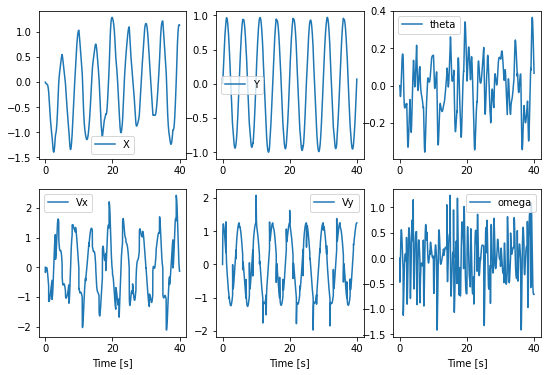

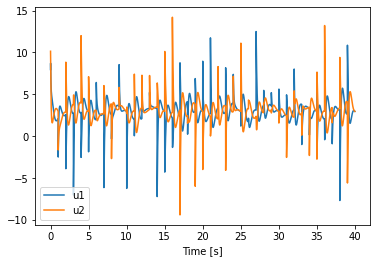

In [9]:
horizon_length = 4000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
z1 = np.zeros([quadrotor.NUMBER_STATES,])

#Set disturbance = False for NO wind
t, state_list, u = quadrotor.simulate(z0, circular_trajectory_LQR_controller, horizon_length, disturbance = True)
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

In [10]:
#Animate the results
quadrotor.animate_robot(state_list, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABZAhtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA20ZYiEABD//veBvzLL
XyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuH+4x2xPbAAAArgAVwJEflNQL71nT4ADkMV
VPbRK84RdyqRUb6gRRR3eFQvVE+KTOH603JMImy4IeauYGfkC5QJLIc84ErblKTJbTqwzR4Yl3kc
jYnKfKjcI37bKL3OEZMXCcYw2mayGHGQhOtp/ofbg//2++sGGRgJage3e3p1cJ4vwELvqcBAznSW
jm9uE69bPcEEqxzH/ygnG5ls/l7oCONpPHi5MF+ablaZmWl5hUMgumz6wVd6Wwzo3vTTHLcW5x54
VVgpQE4V6efu8lQ8/xNkAE8M8Eq9tmpxMlc6Tg+DZcM3/d4/RHEGnHGmMmB5Kcd+ENHo0fX+Y8qA
coMTnIORHj9ledFEYmwJL1R3rQoAAMDVqVPdnWJ/eGvBVaXeZIIIBEcPNv25EjnasIAEeaMzJg9L
+6XmgmYeaTt3NjshJrD/950ZEFLnO5eEOds8/KtTLa78aX2sjQZMpL/hS0xZ5TlFXJi/Tvo+J4SM
yDb/CkU0nALFUn0Bs9juzxaH02BvgLu0/i42i8w0t4gVn6zpm48W6oSdzHLs6XKyGetrSwaZLhHQ
qBm8H3ZC+Tm6cgLIObtX22yJMHPY7S7/p2W8R+SZLpOcPq0Kh1Dzp9yEsVy35RpdGkOvsgxGOSoS
xgte3IegSt0WIhtkiE19poFq28xT04O/k/7gIQO3R7fWQ7+f9UKJViw7aF0dvEFzq3lomsfiuqYQ
a57wPq4Bh3eae4U2oAkNMRF2giNOIMHZdTl8WCTcYliqaAg3FTLfXt2/T57mjEBM2xvAVmHFEu6U
AAAFGbFx7vVzCEKnE7VkJdrtc1MZ7gHwdtxcDA65/XoIM+CmjwYx9oN5bG9+ya/pKA3MDo2z/A1D
/hWwURJoEwFMmEbgHGD4UJE/peZsTaaCskeOgCYYGdKviW1SiCNp+P+CArk7vw46US5Hi/rdVFna
akh6c9fDqf/vA7Ivc/ckac91jjmflIUOtHJsj4R2X5FbAWtE4I4OGOLRxgOuikxwCDDO5Gi2kft9
4iVqcrZZXT4DZAV6mBkw+x2cVfXwFZsGcJjA7dmfAZHc++0+FJFlKnY/NqpWn39/sw64igwc6x6c
Rdn9b2VbHKwoW3kD/VVHUpOu4UTi7q5zPgNXagGHsQw4LpnrMRtOAMLBZwYS3sAAACsBatZv/udD
CsrYeLCJOE1gf5IdQKhKaepHnkWbaGC7scJ8K0eeAhCp+TzVnTljxk7JkKfjI8KcYePuTPP/3psa
+KeAxRm/sNBL7WDj3EoWgHx+YZ82bMMCbvnO2B7z6Gf7uEhmCKbP2mSjp2OEY0JaGlZVc2iIywXH
8VlnpU7162D+3FTTQSeG+f96j7K8nmtKBnwwlR+h+uT/713bDXdulEXoP0i4c+aj/yOUD4/bR5QY
GEWUlSg1p0b7OaCEPfETL5TESf2Ojq82cRy46Tibwntfu8Xxux4iCpp8gDBb5+pBiOk9G3UDmCiU
KO3cZIDFNlZ04I6eRdm10/M9HCKy+QhpxdYSFkHzft7gE7l0wI1smB0LpKcs19fSRrFdUAAHmIAA
wpSA6j5utyhH42sO2Hp1ysDje5c5e/SFuyQEiejZdR2NjkmLnBZIKNh4GqijuZq9etUY844d3BId
v+L76Jt/a7Cf9sWcNIbbbJX4KwHXjtCNiFV/4pUCikH7u+KHDhgcAzz/u8LK3r+ucZ+JOUR29PhV
OM2aXE9cDIgvOaKgbPkOaNvcH9d1+vAw8ezKVwj1gbYa1fybr9xHeB61A15BAfuLFLzaREI9LU3H
C/Onk8KEmgA8qk6Ipxlhx5NMbGR04tBWQ9MKdoprfaszC9wOUIv5uZ6Rjpos12Orq/AglNp7iwiy
0iF7lYeipG4tUHCo/msLpgAOcRsOdL+ZDRuqqoWiv3gW20Mm3VwfUPY/90PFmf2fXhqHArsW8/40
W3Lp2cz6LfNZNWKDU9HGem8sW93FwxvH2L8Xoj344ojYKlg7lvKcXi+NkLKakdFC6+6VWGVZP0Ff
OwyPPIhPXtNCeqDKBEbtrJSqNRNDDzd084Vk8af+JWKu07Ok1/kzqC/HPu1lmxmyZ4jKVpHm10gp
h4RnBX4YYXxC3/QCRfD6gO9oXLjaQ92z0siO76o84ND+TT/ZdIHlzzb7uAABgM/fgAAS1D5AIxZm
NY/dK33yD9GHP8WJT+/CY7LGaDYPkTMCAWl0fHvV4f4n3snWdHYg7H/NtYYut5vXuGIGksAOnu2A
107vwXXH1kSn7WXhx93Sx9oNTu3KJ4AA2u2sK5QqjpvhzucJZHVh7+f8FjAeWcwz1fJshroanKG9
bnJP6DcJ1fNhUz//UB0D+B/orrmT86rt7DS/hP6piJKz/9tFyW0mXf5s2THDy7uiSTvUM08HAhtm
YhPKVeJN7wsrlmNro5SZBNRM6J/dwFCh1AqI6FmYNlwu4UjAmJwRsPlpQS/9ksm7aJOayqPyTzb8
3WvuLf8liv+oIoHjc5V58OXrj31ZThknxRAAAAMAAAMAcig+vNK5x7UYw7iKCJltIVWZxfsjn7Xd
83XiBdnM7c4F2CiwhMeYZt4C3bfc+3fUEsZyvxjnwoccLQu0IoRM9B/7Z4d27WhaVABNv7BZlFNV
k6OjYS5mrmzahwg6Fevws2wd/sIAAGTygX2XcDBghpv9s3SrRNNPniwBNXt4SGSixhbhg/ppylOS
zPmQhWDqU0w7X6EhnI6KV2O50y4+PyQGx8WUSr3TzxXg2/bQU2KOU+bENNuAMurBc2o8jmKcNkeJ
l4704bjULNpRB5zt1HA1PqMlSYw8VW9sAlCGBIpxT9ukAAADAAB42ew23m5/eXh4GsEHDh08i5v/
9n6NzYZ9aCmejJ0/Ytbz3